In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [26]:
#This function creates as many time series as requested 
#and there is just one value per time step in each series (all series are univariate)

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4,batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) #wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size,n_steps) - 0.5) # + noise
    return series[...,np.newaxis].astype(np.float32)

In [4]:
# Let's create a training set, a validation set, and a test set using this function:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train =  series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

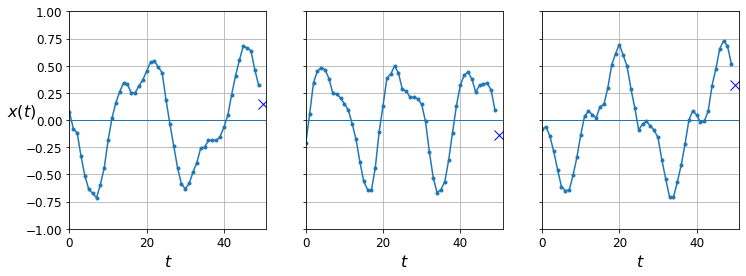

In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

## Baseline Metrics

Before we start using RNNs, it is often oa good idea to have a few baseline metrics,
or else we may end up thinking our model works great when in fact it is doing worse than basic models.

For example, the simplest approach is to predict the last value in each series. This is called naive *naive forescasting*
and it is sometimes suprisingly difficult to outperform. In this case, it gives us a mean squared error of about 0.020:

In [7]:
y_pred = X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

KeyboardInterrupt: 

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer. Let's just use a simple Linear Regression model so that each prediction will be a linear combination of values in the time series:
We get an MSE of about 0.004. That's much better than the naive approach!

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape =[50,1]),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss ='mean_squared_error')
model.fit(X_train,y_train, epochs= 10, validation_data =(X_valid,y_valid))

## Implementing a Simple RNN

Let's see if we can beat that with a simple RNN:

In [ ]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1,input_shape=[None,1])])
model.compile(optimizer='adam', loss ='mean_squared_error')
model.fit(X_train,y_train, epochs= 10, validation_data =(X_valid,y_valid))

That's really the simplest RNN you can build. It just contains a single layer, with a single neuron. We do not need to specify the length of the input sequences since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to *None*) By default, the *SimpleRNN* layer uses the hyperbolic tangent activation function.

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set *return_sequences= True*

## Deep RNNs
Implementing a deep RNN with tf.keras is quite simple: just stack recurrent layers. In this example, we use three *SimpleRNN* layers (but we could add any other type of recurrent layer, such as an LSTM layer or a GRU layer)

In [29]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss ='mean_squared_error')
model.fit(X_train,y_train, epochs= 1, validation_data =(X_valid,y_valid))

219/219 [==============================] - 46s 202ms/step - loss: 0.1423 - val_loss: 0.0071


## Forecasting Several Time Steps Ahead

In [30]:
series = generate_time_series(1,n_steps+ 10)

In [31]:
X_new, y_new = series[:, :n_steps], series[:,n_steps:]
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

y_pred =  X[:,n_steps:]

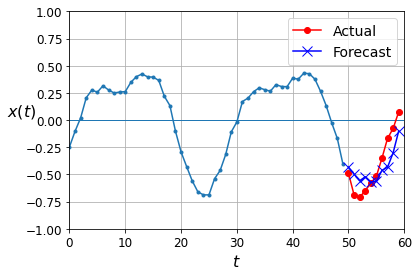

In [32]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, y_new, y_pred)

plt.show()

As you might expect, the prediction for the next step will usually be more accurate than the predictions for later time stpes, since the errors might accumulate.

The second option is to train an RNN to predict all 10 next values at once. We can still use a sequence-to-vector model, but it will output 10 values instead of 1. However, we first need to change the targets to be vectors containing the next 10 values

In [33]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10, 0]

In [34]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences= True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(optimizer='adam', loss ='mean_squared_error')
model.fit(X_train,y_train, epochs= 1, validation_data =(X_valid,y_valid))

219/219 [==============================] - 42s 186ms/step - loss: 0.0717 - val_loss: 0.2156


In [53]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

ValueError: x and y must have same first dimension, but have shapes (10,) and (50, 1)

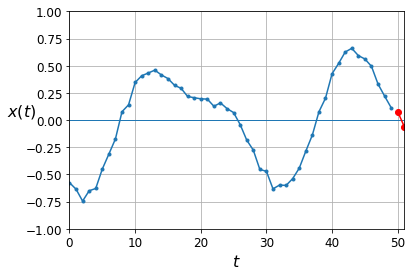

In [54]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()


We can still do better: indeed, instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values only at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won't have to flow only through time; they will also flow from the output of each time step. This will both stabilize and speed up training.

In [55]:
series = generate_time_series(1, 50 + 10)
Y =  np.empty((10000, n_steps,10)) #Each target is a sequence of 10D vectors

for step_ahead in range(1,10+1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead: step_ahead + n_steps, 0]
    Y_train = Y[:7000]
    Y_valid = Y[7000:9000]
    Y_test = Y[9000:]
    
Y.shape

(10000, 50, 10)

To turn the model into a sequence-to-sequence model, we must set return_sequence = True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step. Keras offers a **TimeDistributed** layer for this very purpose:

It wraps any layer( e.g. a Dense layer) and applies it at every time step of its input sequence. It does this efficiently, by reshaping the inputs so that each time step is treated as a seperate instance (i.e., it reshapes the inputs from [batch size, time steps, input dimensions] to [batch size x time steps, input dimensions]; in this example, the number of input dimensions is 20 because the previous SimpleRNN layer has 20 units), it reshapes the outputs from [batch size x time steps, output dimensions] to [batch size, time steps, output dimensions]; in this example the number of output dimensions 10, since the Dense layer has 10 units)

In [40]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [41]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:,-1])

In [44]:
optimizer = keras.optimizers.Adam(lr = 0.01)
model.compile(loss ='mse', optimizer = optimizer, metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 45s 199ms/step - loss: 0.1427 - last_time_step_mse: 0.2116 - val_loss: 0.1087 - val_last_time_step_mse: 0.2615
Epoch 2/20
219/219 [==============================] - 40s 184ms/step - loss: 0.1400 - last_time_step_mse: 0.2137 - val_loss: 0.1282 - val_last_time_step_mse: 0.1777
Epoch 3/20
219/219 [==============================] - 40s 184ms/step - loss: 0.1175 - last_time_step_mse: 0.1427 - val_loss: 0.1140 - val_last_time_step_mse: 0.1170
Epoch 4/20
219/219 [==============================] - 40s 184ms/step - loss: 0.1031 - last_time_step_mse: 0.1408 - val_loss: 0.1434 - val_last_time_step_mse: 0.1808
Epoch 5/20
219/219 [==============================] - 39s 180ms/step - loss: 0.1355 - last_time_step_mse: 0.1763 - val_loss: 0.1332 - val_last_time_step_mse: 0.1396
Epoch 6/20
219/219 [==============================] - 40s 184ms/step - loss: 0.1304 - last_time_step_mse: 0.1682 - val_loss: 0.1215 - val_last_time_step_mse: 0.1711
Epoch 7/20

In [67]:

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

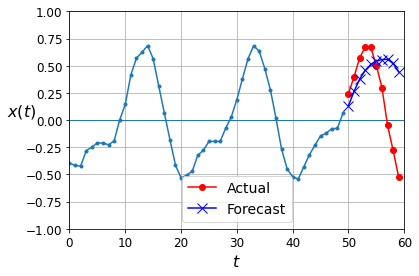

In [61]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Handling Long Sequences

### Fighting the Unstable Gradients Problem

The unstable gradient problem is a fundamental problem that occurs in a neural network, that entails that a gradient in a deep neural network tends to either explode or vanish in early layers.

Batch normalization provides an elegant way of reparametrizing almost any deep network. The reparametrization significantly reduces the problem of coordinating updates across many layers.

However Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only beween recurrent layers. To be more precise, it is technically possible to add a BN layer to a memory cell so that it will be applied at each time step (both on the inputs for that time step and on the hidden state from the previous step) In practice, this does not yield good results. BN was slightly beneficial only when it was applied to the inputs, not to the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers but not within recurrent layers. In Keras this can be done simply by adding a **Batch Normalization** layer before each recurrent layer, but don't expect too much from it.

Another form of normalization often works better with RNNs: **Layer Normalization** It is very similar to Batch Normalization, but instead of normalizing across the batch dimensions, it normalizes across the features dimension. Let's use tf.keras to implement Layer Normalization within a simple memory cell. For this, we need to define a custom memory cell. It is just like regular layer, except its *call()* method takes two arguments: the *inputs* at the current time step and the *hidden states* from the previous time step. Note that the *states* argument is a list containing one or more tensors. In the case of a simple RNN cell it contains a single  tensor equal to the outputs of the previous time step, but other cells may have multiple state tensors.(*LSTMCell* has a long-term state and a short-term state) In a simple RNN, both are simply equal to the number of units. The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each time step:

In [62]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation ='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation= None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Our *LNSimpleRNNCell* class inherits from the **keras.layers.Layer class**, just like any custom layer. The constructor takes the number of units and the desired activation function, and it sets the state_size and output_size attributes, then creates a *SimpleRNNCell* with no activation function (becuase we want to perform Layer Normalization after the linear operation but before the activation function). 

Then the constructor creates the **LayerNormalization layer**, and finally it fetches the desired activation function. The *call()* method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a simple SimpleRNNCell, the outputs are just equal to the hidden states: in other words *new_states[0]* is equal to outputs, so we can safely ignore *new_states* in the rest of the *call()* method) Next the *call()* method applies Layer Normalization, followed by the activation function. Finally, it returns the outputs twice (once as the outputs and once as the new hidden states). To use this custom cell, all we need to do is create a keras.layers.RNN.layer, passing it a cell instance.

In [64]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences = True, input_shape = [None,1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [89]:
optimizer = keras.optimizers.Adam(lr = 0.01)
model.compile(loss ='mse', optimizer = optimizer, metrics = [last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 111s 490ms/step - loss: 0.0794 - last_time_step_mse: 0.0570 - val_loss: 0.0152 - val_last_time_step_mse: 0.0165
Epoch 2/20
219/219 [==============================] - 102s 467ms/step - loss: 0.0140 - last_time_step_mse: 0.0184 - val_loss: 0.0035 - val_last_time_step_mse: 0.0074
Epoch 3/20
219/219 [==============================] - 98s 447ms/step - loss: 0.0019 - last_time_step_mse: 0.0032 - val_loss: 4.7054e-04 - val_last_time_step_mse: 2.1672e-04
Epoch 4/20
219/219 [==============================] - 99s 450ms/step - loss: 4.0809e-04 - last_time_step_mse: 1.7152e-04 - val_loss: 2.9586e-04 - val_last_time_step_mse: 7.9325e-05
Epoch 5/20
219/219 [==============================] - 97s 443ms/step - loss: 2.8993e-04 - last_time_step_mse: 1.5347e-04 - val_loss: 2.3057e-04 - val_last_time_step_mse: 3.4275e-05
Epoch 6/20
219/219 [==============================] - 99s 453ms/step - loss: 2.4001e-04 - last_time_step_mse: 1.3980e-04 - val_loss: 

In [90]:

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

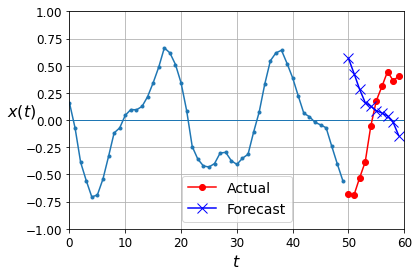

In [91]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()